# Differential gene expression pipeline 
counts are generated using HTSeq \
DGE is calculated using DESeq2

In [2]:
# just through a couple hoops to load tidyverse and DESeq2

.libPaths('/anaconda3/lib/R/library')
library(tidyverse)


.libPaths('/home/kristin/R/x86_64-pc-linux-gnu-library/3.6/')
library(DESeq2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘DESeq2’ was built under R version 3.6.3”
Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 3.6.3”
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 3.6.3”
Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSap

### TS559 exoS vs statS
we have two replicates for both exponential and stationary growth phases, so we will prototype pipeline using these samples. 

In [4]:
# load counts generated from HTSeq

exoS_dec <- read_delim('../raw_data/TS559exoS_dec_counts', delim='\t',col_names=c("gene_id", "exoS_dec"))
exoS_march <- read_delim('../raw_data/TS559exoS_march_counts', delim='\t',col_names=c("gene_id", "exoS_march"))

statS_dec <- read_delim('../raw_data/TS559statS_dec_counts', delim='\t',col_names=c("gene_id", "statS_dec"))
statS_march <- read_delim('../raw_data/TS559statS_march_counts', delim='\t',col_names=c("gene_id", "statS_march"))

Parsed with column specification:
cols(
  gene_id = col_character(),
  exoS_dec = col_double()
)

Parsed with column specification:
cols(
  gene_id = col_character(),
  exoS_march = col_double()
)

Parsed with column specification:
cols(
  gene_id = col_character(),
  statS_dec = col_double()
)

Parsed with column specification:
cols(
  gene_id = col_character(),
  statS_march = col_double()
)



In [5]:
# create count matrix

matrix <- exoS_dec %>% 
    merge(exoS_march, all=TRUE, by = "gene_id") %>% 
    merge(statS_dec, all=TRUE, by = "gene_id") %>% 
    merge(statS_march, all=TRUE, by = "gene_id") %>%
    arrange(gene_id)

countData <- matrix[6:nrow(matrix),]

head(countData)
tail(countData)

,gene_id,exoS_dec,exoS_march,statS_dec,statS_march
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
6,TK0001,11979,2116,13079,2242
7,TK0002,911,171,837,125
8,TK0003,172,32,182,19
9,TK0004,1872,314,1150,275
10,TK0005,972,293,699,178
11,TK0006,1353,274,988,164


,gene_id,exoS_dec,exoS_march,statS_dec,statS_march
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2304,TK2301,1322,175,853,273
2305,TK2302,3102,443,1700,367
2306,TK2303,5535,274,3682,6766
2307,TK2304,11159,1749,4616,1116
2308,TK2305,169,50,202,44
2309,TK2306,492,114,467,94


In [43]:
# create metadata

sample_name <- c("exoS_dec", "exoS_march", "statS_dec", "statS_march")
sample_type <- c("exoS", "exoS", "statS", "statS")

metaData <- data.frame(sample_name, sample_type) %>% mutate(celltype="TS559")

metaData

sample_name,sample_type,celltype
<fct>,<fct>,<chr>
exoS_dec,exoS,TS559
exoS_march,exoS,TS559
statS_dec,statS,TS559
statS_march,statS,TS559


In [44]:
# create object of DGE

dds <- DESeqDataSetFromMatrix(countData=countData, 
                              colData=metaData, 
                              design=~sample_type, tidy = TRUE)


converting counts to integer mode



In [45]:
# calculate differential gene expression (dge)

dge <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [46]:
# Look at data results (dge_results)

dge_results <- results(dge)
summary(dge_results)

head(results(dge, tidy=TRUE))


out of 2292 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 240, 10%
LFC < 0 (down)     : 64, 2.8%
outliers [1]       : 0, 0%
low counts [2]     : 89, 3.9%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TK0001,5242.86351,0.2535372,0.4318480,0.5870982,0.5571378,0.8823736
2,TK0002,359.59625,-0.1174353,0.4796616,-0.2448295,0.8065885,0.9655149
3,TK0003,68.06794,-0.0694228,0.6474560,-0.1072240,0.9146113,0.9899801
4,TK0004,658.89857,-0.3099270,0.4460632,-0.6948051,0.4871774,0.8326323
5,TK0005,446.77107,-0.4971459,0.4893297,-1.0159734,0.3096421,0.6918271
6,TK0006,502.03245,-0.4429453,0.4620374,-0.9586783,0.3377208,0.7238716


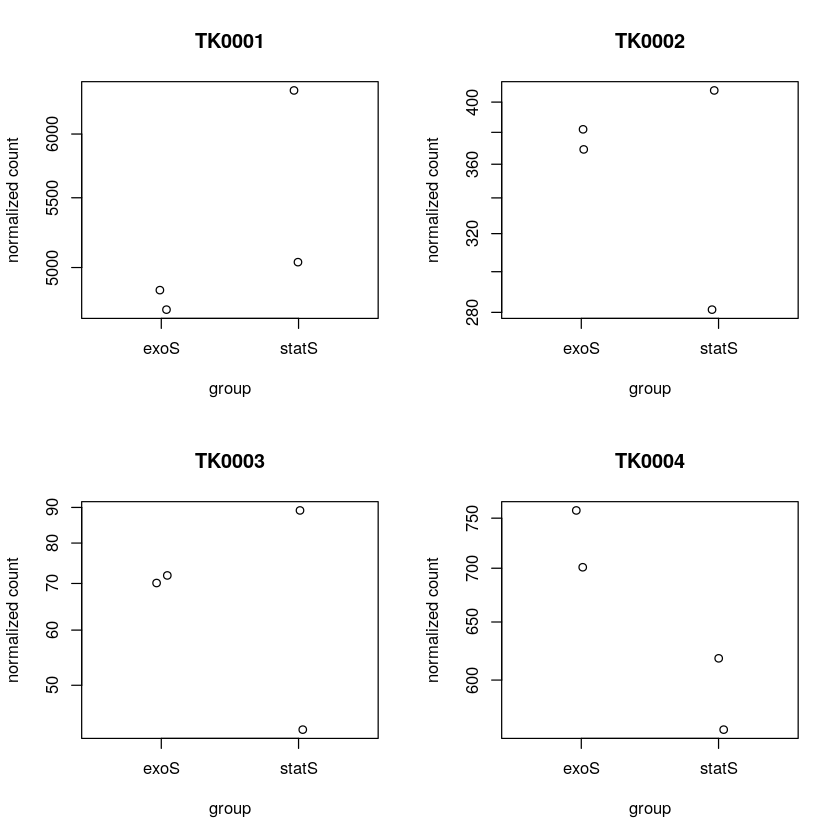

In [47]:
# if you want to see normalized read counts for specified genes
par(mfrow=c(2,2))

plotCounts(dge, gene="TK0001", intgroup="sample_type")
plotCounts(dge, gene="TK0002", intgroup="sample_type")
plotCounts(dge, gene="TK0003", intgroup="sample_type")
plotCounts(dge, gene="TK0004", intgroup="sample_type")

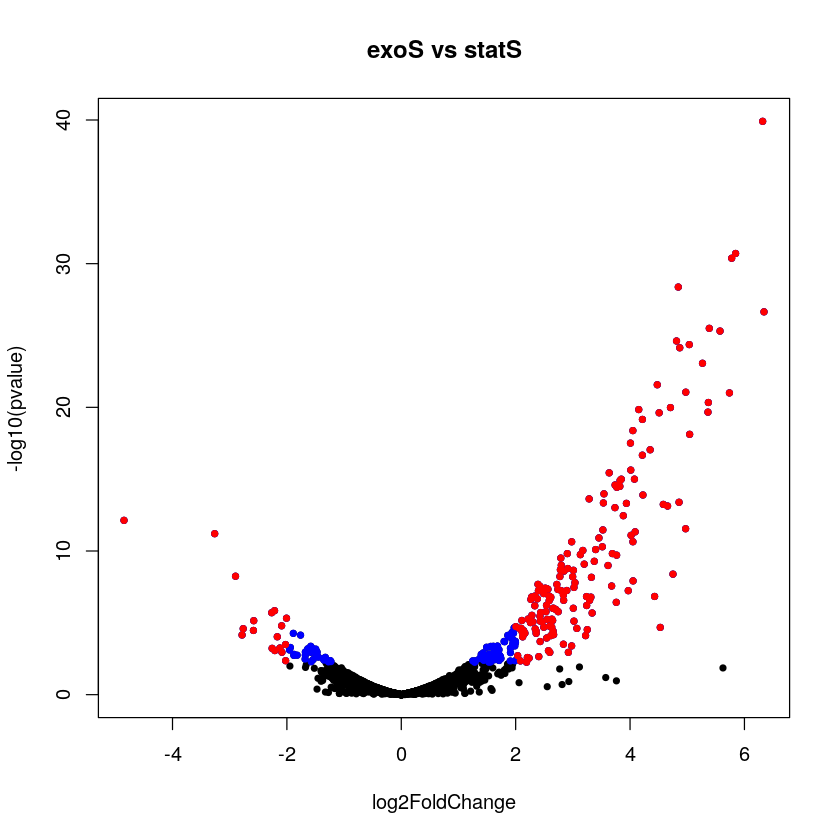

In [48]:
# volcano plot

#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(dge_results, plot(log2FoldChange, -log10(pvalue), 
                       pch=20, main="exoS vs statS" 
                       ))

# Add colored points: blue if padj<0.05, red if absolute value of log2FC>1 and padj<0.01)
with(subset(dge_results, padj<.05 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(dge_results, padj<.05 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

In [49]:
# create data matrix of differentially expressed genes

results_tidy <- data.frame(results(dge, tidy=TRUE))

dge_2xFC_table <- results_tidy %>% 
    filter(log2FoldChange >= 1 | log2FoldChange <= -1) %>%
    filter(padj <= 0.05) %>%
    arrange(padj)

dge_3xFC_table <- results_tidy %>% 
    filter(log2FoldChange >= 1.5 | log2FoldChange <= -1.5) %>%
    filter(padj <= 0.05) %>%
    arrange(padj)

# count differentially expressed genes and show first 6

print(paste("number of 2xFC differentially expressed genes:",nrow(dge_2xFC_table)))
print(paste("down regulated:", nrow(dge_2xFC_table %>% filter(log2FoldChange<=-1))))
print(paste("up regulated:", nrow(dge_2xFC_table %>% filter(log2FoldChange>=1))))

head(dge_2xFC_table)

print(paste("number of 3xFC differentially expressed genes:",nrow(dge_3xFC_table)))
head(dge_3xFC_table)

[1] "number of 2xFC differentially expressed genes: 263"
[1] "down regulated: 48"
[1] "up regulated: 215"


,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TK2298,2292.1759,6.318752,0.4734312,13.34672,1.237834e-40,2.726949e-37
2,TK2299,741.4184,5.845604,0.5011771,11.66375,1.952523e-31,2.150705e-28
3,TK0427,2118.0270,5.776949,0.4980809,11.59842,4.197717e-31,3.082523e-28
4,TK1463,10706.4538,4.843508,0.4325912,11.19650,4.241619e-29,2.336072e-26
5,TK1818,958.4343,6.342055,0.5851180,10.83893,2.250803e-27,9.917037e-25
6,TK2072,4250.1684,5.385563,0.5083575,10.59405,3.175600e-26,1.165975e-23


[1] "number of 3xFC differentially expressed genes: 240"


,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TK2298,2292.1759,6.318752,0.4734312,13.34672,1.237834e-40,2.726949e-37
2,TK2299,741.4184,5.845604,0.5011771,11.66375,1.952523e-31,2.150705e-28
3,TK0427,2118.0270,5.776949,0.4980809,11.59842,4.197717e-31,3.082523e-28
4,TK1463,10706.4538,4.843508,0.4325912,11.19650,4.241619e-29,2.336072e-26
5,TK1818,958.4343,6.342055,0.5851180,10.83893,2.250803e-27,9.917037e-25
6,TK2072,4250.1684,5.385563,0.5083575,10.59405,3.175600e-26,1.165975e-23


In [50]:
# write dge_2xFC_table to new file

#write.table(dge_2xFC_table, file = './dge_2xFC_table', sep='\t',row.names=F)